<a href="https://colab.research.google.com/github/shivsharanrupesh/GenAI_Agents_Journey/blob/main/Langgraph/Langgraph_Chains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chain
Review
We built a simple graph with nodes, normal edges, and conditional edges.

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes

In [32]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [17]:
pip install langchain_groq langgraph langgraph-cli[inmem] langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.3 MB/s eta 0:00:00


In [33]:
from openai import OpenAI
from google.colab import userdata
api_key = userdata.get('GROQ_API_KEY')

In [34]:
from langchain_groq import ChatGroq
client = OpenAI(api_key=api_key)
llm=ChatGroq(model="qwen-2.5-32b", api_key=api_key)
result=llm.invoke(messages)
result

AIMessage(content="Orcas, also known as killer whales, can be spotted in various parts of the United States, but some areas are more reliable for sightings than others. Here are a few prime locations where you might have a good chance of seeing orcas:\n\n1. **San Juan Islands, Washington**: Located in the northern part of Puget Sound, the San Juan Islands are a popular spot for orca watching. The area is home to the Southern Resident killer whale population, which is a distinct community of orcas known to frequent the waters around the islands. Many tour companies offer whale-watching tours from the islands.\n\n2. **Seattle, Washington**: Just a short boat ride from Seattle, the waters around the city are another excellent place to see orcas. Whale-watching tours depart from Seattle and are a popular way to see orcas as well as other marine wildlife.\n\n3. **Alaska**: The waters of Alaska, particularly around Juneau, are rich in marine life, and orcas can be seen there throughout much 

In [35]:
def add(a: int, b: int) -> int:
    """
    Adds two integers and returns the result.

    Args:
    -----
    a (int): The first integer.
    b (int): The second integer.

    Returns:
    --------
    int: The sum of `a` and `b`.
    """
    return a + b


In [36]:
# Bind the "add" function as a tool for the language model
llm_with_tools = llm.bind_tools([add])

In [37]:
# Invoke the LLM with a human message asking for an addition calculation
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 plus 3", name="Lance")])

# Print the response
print(tool_call)


content='' additional_kwargs={'tool_calls': [{'id': 'call_2aqf', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 197, 'total_tokens': 222, 'completion_time': 0.125, 'prompt_time': 0.01231808, 'queue_time': 0.236261595, 'total_time': 0.13731808}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-80972a2c-a143-4106-9b95-49569301d4b6-0' tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_2aqf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 197, 'output_tokens': 25, 'total_tokens': 222}


In [38]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    """
    Represents the state structure for storing and managing messages in a conversational AI system.

    Attributes:
    -----------
    messages : list[AnyMessage]
        A list of messages exchanged within the conversation.
        The `add_messages` function from `langgraph` ensures new messages are appended properly.
    """
    messages: Annotated[list[AnyMessage], add_messages]


In [13]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on generative ai.", name="Rupesh")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_message,new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='c022c499-1e55-4c06-802d-7f958d69d4dd'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Rupesh', id='a2979d57-ed85-4ea5-bd5b-f32a6a1deaf5'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='fab66961-ae3b-414c-a031-855cfea0a56c')]

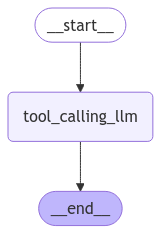

In [40]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessageState):
    """
    Processes the input messages using the LLM and returns updated messages.

    Parameters:
    ----------
    state (MessageState): A dictionary containing a list of messages.

    Returns:
    --------
    MessageState: The updated state with the LLM response added.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages=graph.invoke({"messages":HumanMessage(content="What is 2 minus 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 minus 3
================================== Ai Message ==================================

The operation you asked for is subtraction, but the function I have for addition. However, I can help you solve 2 minus 3 without needing to call a function, as it is a simple arithmetic operation. 

2 minus 3 equals -1.


In [18]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """
    Multiplies two integers and returns the result.

    Args:
    -----
    a (int): The first integer.
    b (int): The second integer.

    Returns:
    --------
    int: The product of `a` and `b`.
    """
    return a * b


### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

In [26]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)
llm = ChatOpenAI(model="gpt-4o", api_key=api_key)
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-8aab0a8d-9052-4db6-9856-65da819b94e8-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [27]:
# Bind the multiply and add functions as tools for the LLM
llm_with_tools = llm.bind_tools([multiply,add])

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [29]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

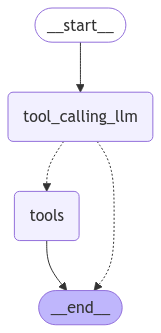

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

# Node: Calls the LLM with the current messages state
def tool_calling_llm(state: MessagesState):
    """
    Invokes the LLM with the given message history.

    Args:
        state (MessagesState): The current conversation state containing messages.

    Returns:
        MessagesState: The updated state with the LLM's response.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("tool_calling_llm", tool_calling_llm)  # Node for LLM invocation
builder.add_node("tools", ToolNode([multiply, add]))  # Node for tool execution

# Define edges (flow of execution)
builder.add_edge(START, "tool_calling_llm")  # Start at LLM node

# Conditional edge: Determines if the LLM's response includes a tool call
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,  # Routes to "tools" if a tool is needed; otherwise, ends
)

builder.add_edge("tools", END)  # If tools are executed, the process ends

# Compile the graph
graph = builder.compile()

# View the graph structure as an image
display(Image(graph.get_graph().draw_mermaid_png()))


In [42]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_pwsq)
 Call ID: call_pwsq
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
